In [14]:
using ChaosTools
using DynamicalSystems
using PyPlot
using OrdinaryDiffEq, LinearAlgebra, ForwardDiff, PyPlot
using Distributions

In [18]:
PyPlot.pygui(false)

false

In [3]:

x = rand(Truncated(Normal(0, 1.), -1., 1.), 100)
x=x.-8
y=rand(Truncated(Normal(0, 1.), -1.5, 1.5), 100)
grid=Iterators.product(x,y)
grid=collect.(grid)
println(grid[1])
println(grid[1][1])
#pre(grid[1][1],grid[1][2],m[1],m[2],a,b,Hinicial)

[-8.154765994085343, -0.27987423368640524]
-8.154765994085343


In [119]:
Xraros=[-33.4, -33.8, -33.5,-33.2, -33.2]
Praros=[-1.49, -1.48, -1.46, -1.46, -1.5]
#xraros=[33.4, 33.8, 33.5,33.2, 33.2]
#Praros=[1.49, 1.48, 1.46, 1.46, 1.5]

5-element Array{Float64,1}:
 -1.49
 -1.48
 -1.46
 -1.46
 -1.5 

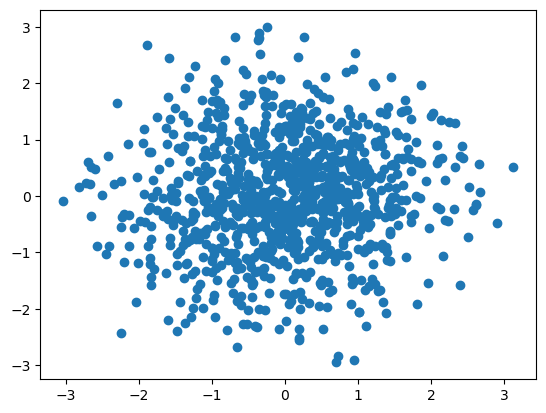

  0.000019 seconds (5 allocations: 8.094 KiB)
  0.000009 seconds (5 allocations: 8.094 KiB)
  0.000132 seconds (19 allocations: 32.117 KiB)
  0.000104 seconds (19 allocations: 32.117 KiB)


1000-element Array{Float64,1}:
 1.4414780833018517
 1.4312713988596182
 1.3316155032216794
 1.3215830013825978
 1.5109994588532238
 1.2347393366013986
 1.4345162846999426
 1.5860433905635298
 1.6003141923867372
 1.3048516482411916
 1.4450423191551838
 1.51627863079532  
 1.3977018959012228
 ⋮                 
 1.320133402488806 
 1.3527740717034074
 1.3977965075252443
 1.4268826337848544
 1.6391865791669502
 1.5168917794099754
 1.539784113535436 
 1.4539282374875122
 1.4867012497406915
 1.3571862741725338
 1.4294410254476329
 1.3613182329527955

In [15]:
arraysize=1000
@time u1 = rand(arraysize)
@time u2 = rand(arraysize)
@time z0 = map.(sqrt,-2* map.(log,u1)) .*map.(cos,2. *pi*u2)
@time z1 = map.(sqrt,-2* map.(log,u1)) .*map.(sin,2. *pi*u2)
scatter(z0,z1)

xz0=z0*0.15
pz1=z1*0.1
Xz0=z0 .-33.5
Pz1=z1*0.1 .+1.45

#x=x.-8
#y=rand(Truncated(Normal(0, 1.), -1.5, 1.5), 100)
#grid=Iterators.product(x,y)
#grid=collect.(grid)
#println(grid[1])
#println(grid[1][1])

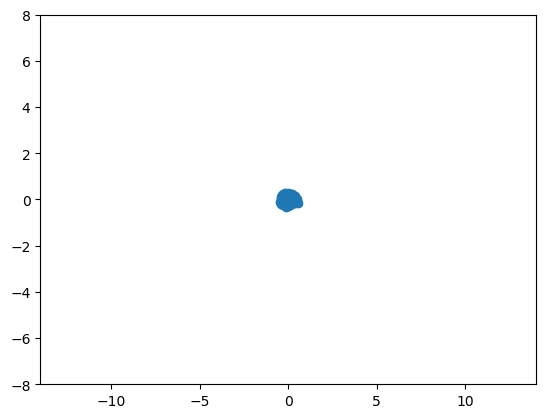

(-14, 14)

In [4]:
scatter(xz0,pz1)
ylim(-8,8)
xlim(-14,14)


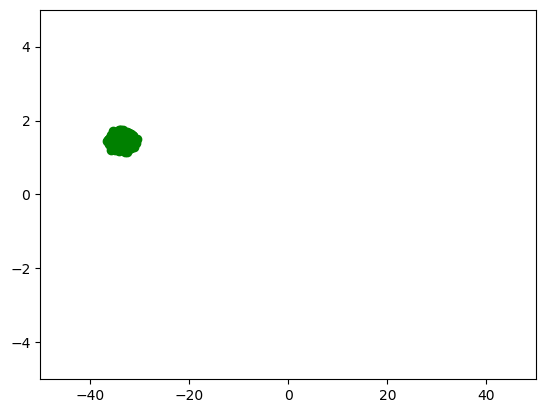

(-50, 50)

In [16]:
scatter(Xz0,Pz1,color="g")
ylim(-5,5)
xlim(-50,50)

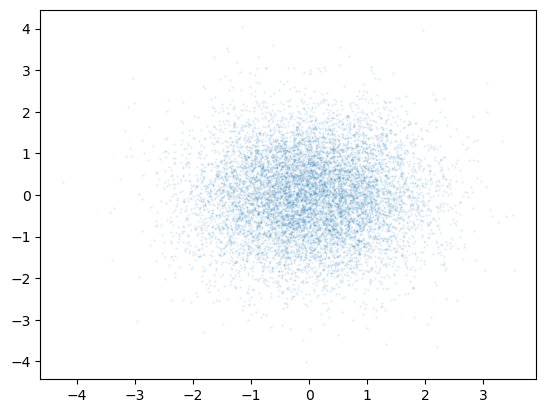

  0.177388 seconds (174.54 k allocations: 8.984 MiB)


PyObject <matplotlib.collections.PathCollection object at 0x14f35d590>

In [6]:
@time scatter(z0,z1,alpha=0.1,s=0.5)

In [6]:
initial_position = [0.1, 0.]
initial_momentum=[0. ,0.1]

2-element Array{Float64,1}:
 0.0
 0.1

In [21]:
function energia_poinc_abs(x0, p0, m0, M0, a0, b0, H0)
    return (2. *M0*(H0-p0*p0/(2. *m0)+a*x0*x0/2. -b*x0*x0*x0*x0/4. ))^(1. /2. )
end
epsilon=0.01
m=[1.,0.1]
w=[0.,0.8]
g=[0.,0.1]
a=0.25
b=0.01
entmutua=[]
entsys=[]
entpozo=[]
entosci=[]
time=100.
dts=1//100
entropies=zeros(100)
Q1=[]
Q2=[]
P1=[]
P2=[]
tspan=(0., time)
k=0
sol3=0

m[2]=0.1
w[2]=0.7071
g[2]=0.05
dts=0.001*2. *pi/w[2]
Hsys(q,p) = p[1]^2. /(2. *m[1]) - a*q[1]^2. /2. +b*q[1]^4. /4. +q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. 
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p), p)
initial_position[2]=0.

@time for jj =1:10000
    #println(jj)
    Hinicial=15.0
    initial_position[1]=grid[jj][1]
    initial_momentum[1]=grid[jj][2]
    
    initial_momentum[2]=energia_poinc_abs(initial_position[1],initial_momentum[1],m[1],m[2],a,b,Hinicial) #osciladores
    prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
    sol3 = solve(prob, CalvoSanz4(), dt=dts);
    #@time sol3 = solve(prob, CalvoSanz4(), dt=dts);
    push!(Q1,sol3[3,1:10:end])
    push!(Q2,sol3[4,1:10:end])
    push!(P1,sol3[1,1:10:end])
    push!(P2,sol3[2,1:10:end])
    k=sol3
    

end
dim=length(Q2[1])
Q1=reduce(hcat,Q1)
Q2=reduce(hcat,Q2)
P1=reduce(hcat,P1)
P2=reduce(hcat,P2)
system=cat(Q1,Q2,P1,P2,dims=3)
pozo=cat(Q1,P1,dims=3)
oscilador=cat(Q2,P2,dims=3)
println(dim)
bbb=0
ccc=0

#draw()
@time for iiii in 1:dim
    num=lpad(iiii,8,"0")
    systemdata=Dataset(system[iiii,:,:])
    push!(entsys,genentropy(1, epsilon, systemdata;base=2.))
    pozodata=Dataset(pozo[iiii,:,:])
    if iiii==20
        bbb=pozodata
    end
    if iiii%5==0
        PyPlot.scatter(pozodata[:,1],pozodata[:,2], alpha=0.4, s=1.5)
        ylim(-6,6)
        xlim(-11,11)
        xlabel("x")
        ylabel("p")
        title("Espacio de fase del pozo")
        savefig("gifs/pozo$num.png")
        clf()
    end


    push!(entpozo,genentropy(1, epsilon, pozodata;base=2.))
    oscidata=Dataset(oscilador[iiii,:,:])
    if iiii==20
        ccc=oscidata
    end
    if iiii%5==0
        PyPlot.scatter(oscidata[:,1],oscidata[:,2], alpha=0.4, s=1.5)
        ylim(-2.5,2.5)
        xlim(-35,35)
        xlabel("x")
        ylabel("p")
        title("Espacio de fase del oscilador")
        savefig("gifs/osci$num.png")
        clf()
    end
    push!(entosci,genentropy(1, epsilon, oscidata;base=2.))
    push!(entmutua,entpozo[iiii]+entosci[iiii]-entsys[iiii])
end
#waitforbuttonpress()
#println(entsys)
#println(entpozo)
#println(entosci)
#println(entmutua)

BoundsError: BoundsError: attempt to access 70×70 Array{Array{Float64,1},2} at index [4901]

In [20]:
lim=1000
plot(entsys[1:400],label="system information")
plot(entpozo[1:400],label="particle information")
plot(entosci[1:400],label="oscillator information")
plot(entmutua[1:400],label="mutual information")
legend()
xlabel("time steps / 10")
ylabel("Shannon Information")
title("Mutual Information")
savefig("mutualinfo.png")
clf()

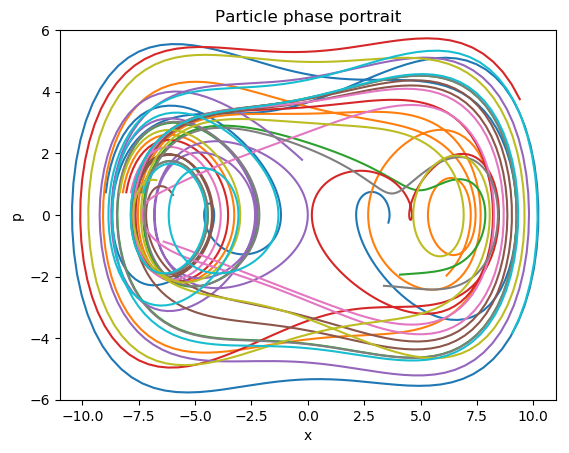

In [68]:
plot(Q1[1:400,1:10],P1[1:400,1:10])
title("Particle phase portrait")
xlabel("x")
ylabel("p")
ylim(-6,6)
xlim(-11,11)
savefig("mutualinfo_phase.png")
clf()

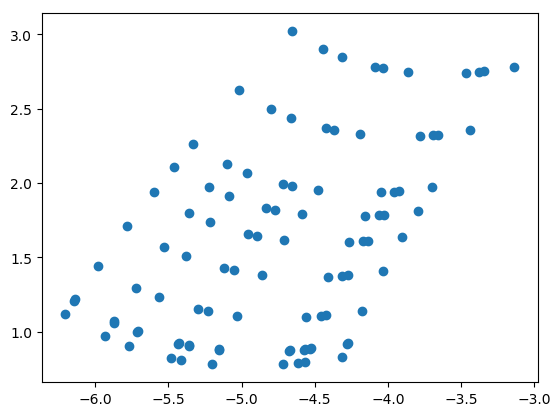

PyObject <matplotlib.collections.PathCollection object at 0x7f66095d7c50>

In [36]:
PyPlot.scatter(bbb[:,1],bbb[:,2])


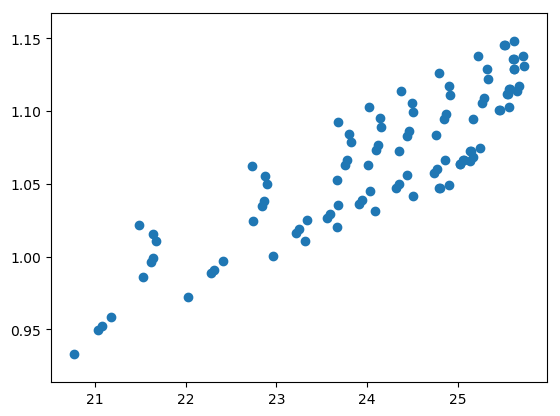

PyObject <matplotlib.collections.PathCollection object at 0x7f660805fe48>

In [62]:
PyPlot.scatter(ccc[:,1],ccc[:,2])

# Usando Box-Muller

In [34]:
initial_position = [0.1, 0.]
initial_momentum=[0. ,0.1]

function energia_poinc_abs(x0, p0, m0, M0, a0, b0, H0)
    return (2. *M0*(H0-p0*p0/(2. *m0)+a*x0*x0/2. -b*x0*x0*x0*x0/4. ))^(1. /2. )
end
epsilon=0.01
m=[1.,0.1]
w=[0.,0.8]
g=[0.,0.1]
a=0.25
b=0.01
entmutua=[]
entsys=[]
entpozo=[]
entosci=[]
#time=100.
time=20.
dts=1//100
entropies=zeros(100)
Q1=[]
Q2=[]
P1=[]
P2=[]
tspan=(0., time)
k=0
sol3=0

m[2]=0.1
w[2]=0.7071
g[2]=0.07
dts=0.01*2. *pi/w[2]
Hsys(q,p) = p[1]^2. /(2. *m[1]) - a*q[1]^2. /2. +b*q[1]^4. /4. +q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. 
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p), p)
initial_position[2]=0.
arraysize=5

@time for jj =1:arraysize
    if jj %100==0
        println(jj/arraysize)
    end
    #Hinicial=15.0
    initial_position[1]=0. #xz0[jj]
    initial_momentum[1]=0. #pz1[jj]
    initial_position[2]=Xraros[jj]#Xz0[jj]
    initial_momentum[2]=Praros[jj]#Pz1[jj]
    
    prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
    sol3 = solve(prob, CalvoSanz4(), dt=dts);
    #@time sol3 = solve(prob, CalvoSanz4(), dt=dts);
    push!(Q1,sol3[3,1:1:end])
    push!(Q2,sol3[4,1:1:end])
    push!(P1,sol3[1,1:1:end])
    push!(P2,sol3[2,1:1:end])
    k=sol3
    #plot(sol3[3,:])
    

end
dim=length(Q2[1])
Q1=reduce(hcat,Q1)
Q2=reduce(hcat,Q2)
P1=reduce(hcat,P1)
P2=reduce(hcat,P2)
system=cat(Q1,Q2,P1,P2,dims=3)
pozo=cat(Q1,P1,dims=3)
oscilador=cat(Q2,P2,dims=3)
println(dim)
bbb=0
ccc=0

#draw()
@time for iiii in 1:dim
    num=lpad(iiii,8,"0")
    systemdata=Dataset(system[iiii,:,:])
    push!(entsys,genentropy(1, epsilon, systemdata;base=2.))
    pozodata=Dataset(pozo[iiii,:,:])
    if iiii==20
        bbb=pozodata
    end
    if iiii%1==0#5==0
        #PyPlot.scatter(pozodata[:,1],pozodata[:,2], alpha=0.4, s=1.2)
        PyPlot.scatter(pozodata[:,1],pozodata[:,2])
        ylim(-10,10)
        xlim(-18,18)
        xlabel("x")
        ylabel("p")
        title("Espacio de fase del pozo")
        savefig("gifs/boxmuller/pozo$num.png")
        clf()
    end


    push!(entpozo,genentropy(1, epsilon, pozodata;base=2.))
    oscidata=Dataset(oscilador[iiii,:,:])
    if iiii==20
        ccc=oscidata
    end
    if iiii%1==0#5==0
        #PyPlot.scatter(oscidata[:,1],oscidata[:,2], alpha=0.4, s=1.2)
        PyPlot.scatter(oscidata[:,1],oscidata[:,2])
        ylim(-5,5)
        xlim(-50,50)
        xlabel("x")
        ylabel("p")
        title("Espacio de fase del oscilador")
        savefig("gifs/boxmuller/osci$num.png")
        clf()
    end
    push!(entosci,genentropy(1, epsilon, oscidata;base=2.))
    push!(entmutua,entpozo[iiii]+entosci[iiii]-entsys[iiii])
end
#waitforbuttonpress()
#println(entsys)
#println(entpozo)
#println(entosci)
#println(entmutua)

  2.196594 seconds (3.60 M allocations: 163.076 MiB, 1.18% gc time)
227
 67.921624 seconds (133.51 k allocations: 4.350 MiB)


In [18]:
lim=arraysize
plot(entsys[1:end],label="system information")
plot(entpozo[1:end],label="particle information")
plot(entosci[1:end],label="oscillator information")
plot(entmutua[1:end],label="mutual information")
legend()
xlabel("time steps / 10")
ylabel("Shannon Information")
title("Mutual Information")
savefig("zonarara_g0-07_division_mutualinfo_boxmuller.png")
clf()

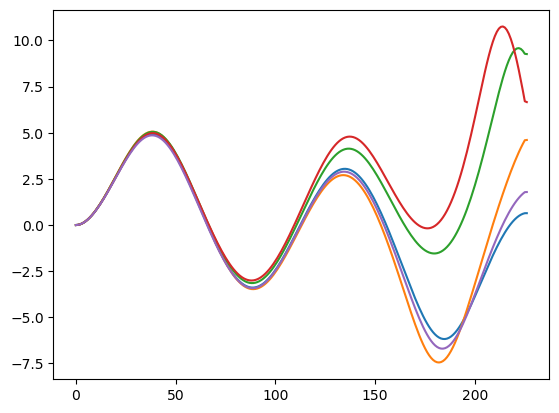

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14eab5590>

In [37]:
initial_position[1]=0. #xz0[jj]
initial_momentum[1]=0. #pz1[jj]
initial_position[2]=Xraros[1]#Xz0[jj]
initial_momentum[2]=Praros[1]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(sol3[3,:])
initial_position[2]=Xraros[2]#Xz0[jj]
initial_momentum[2]=Praros[2]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(sol3[3,:])
initial_position[2]=Xraros[3]#Xz0[jj]
initial_momentum[2]=Praros[3]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(sol3[3,:])
initial_position[2]=Xraros[4]#Xz0[jj]
initial_momentum[2]=Praros[4]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(sol3[3,:])
initial_position[2]=Xraros[5]#Xz0[jj]
initial_momentum[2]=Praros[5]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(sol3[3,:])


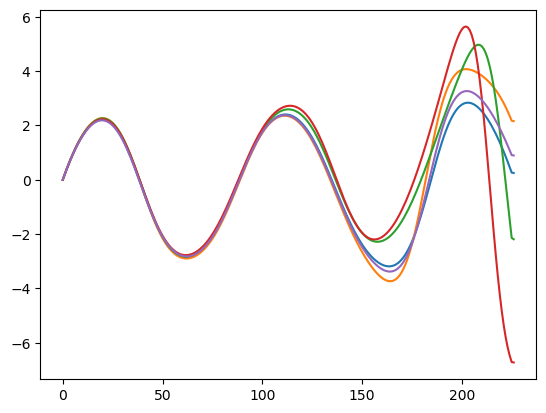

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x159ebafd0>

In [39]:
initial_position[1]=0. #xz0[jj]
initial_momentum[1]=0. #pz1[jj]
initial_position[2]=Xraros[1]#Xz0[jj]
initial_momentum[2]=Praros[1]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(sol3[1,:])
initial_position[2]=Xraros[2]#Xz0[jj]
initial_momentum[2]=Praros[2]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(sol3[1,:])
initial_position[2]=Xraros[3]#Xz0[jj]
initial_momentum[2]=Praros[3]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(sol3[1,:])
initial_position[2]=Xraros[4]#Xz0[jj]
initial_momentum[2]=Praros[4]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(sol3[1,:])
initial_position[2]=Xraros[5]#Xz0[jj]
initial_momentum[2]=Praros[5]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(sol3[1,:])

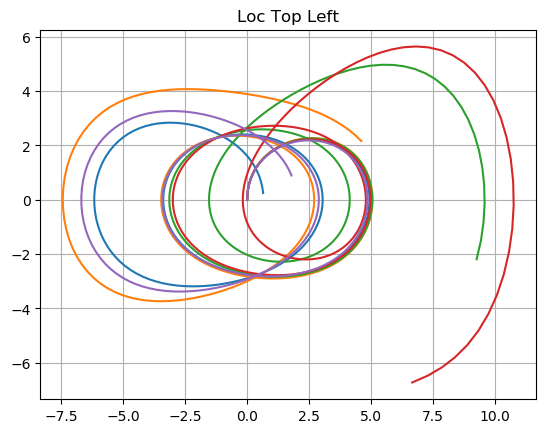

PyObject Text(0.5, 1, 'Loc Top Left')

In [56]:
initial_position[1]=0. #xz0[jj]
initial_momentum[1]=0. #pz1[jj]
initial_position[2]=Xraros[1]#Xz0[jj]
initial_momentum[2]=Praros[1]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(sol3[3,:],sol3[1,:])
initial_position[2]=Xraros[2]#Xz0[jj]
initial_momentum[2]=Praros[2]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(sol3[3,:],sol3[1,:])
initial_position[2]=Xraros[3]#Xz0[jj]
initial_momentum[2]=Praros[3]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(sol3[3,:],sol3[1,:])
initial_position[2]=Xraros[4]#Xz0[jj]
initial_momentum[2]=Praros[4]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(sol3[3,:],sol3[1,:])
initial_position[2]=Xraros[5]#Xz0[jj]
initial_momentum[2]=Praros[5]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(sol3[3,:],sol3[1,:])
PyPlot.grid(true)
title("Loc Top Left")

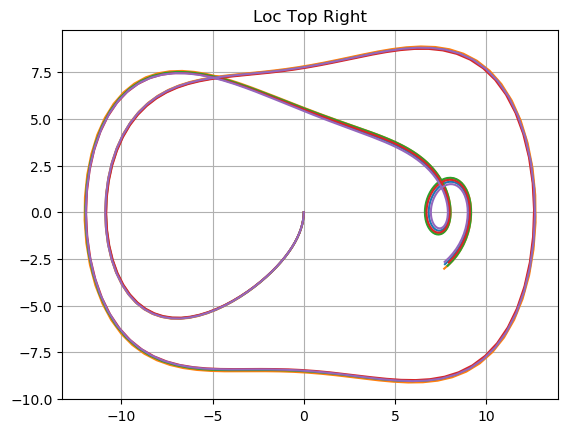

PyObject Text(0.5, 1, 'Loc Top Right')

In [54]:
initial_position[1]=0. #xz0[jj]
initial_momentum[1]=0. #pz1[jj]
initial_position[2]=Xraros[1]#Xz0[jj]
initial_momentum[2]=Praros[1]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(sol3[3,:],sol3[1,:])
initial_position[2]=Xraros[2]#Xz0[jj]
initial_momentum[2]=Praros[2]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(sol3[3,:],sol3[1,:])
initial_position[2]=Xraros[3]#Xz0[jj]
initial_momentum[2]=Praros[3]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(sol3[3,:],sol3[1,:])
initial_position[2]=Xraros[4]#Xz0[jj]
initial_momentum[2]=Praros[4]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(sol3[3,:],sol3[1,:])
initial_position[2]=Xraros[5]#Xz0[jj]
initial_momentum[2]=Praros[5]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(sol3[3,:],sol3[1,:])
PyPlot.grid(true)
title("Loc Top Right")

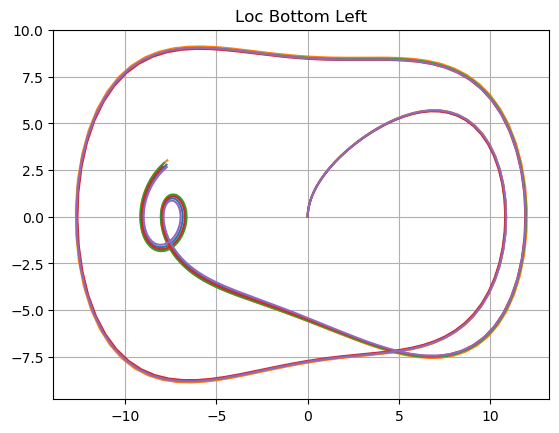

PyObject Text(0.5, 1, 'Loc Bottom Left')

In [58]:
initial_position[1]=0. #xz0[jj]
initial_momentum[1]=0. #pz1[jj]
initial_position[2]=Xraros[1]#Xz0[jj]
initial_momentum[2]=Praros[1]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(sol3[3,:],sol3[1,:])
initial_position[2]=Xraros[2]#Xz0[jj]
initial_momentum[2]=Praros[2]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(sol3[3,:],sol3[1,:])
initial_position[2]=Xraros[3]#Xz0[jj]
initial_momentum[2]=Praros[3]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(sol3[3,:],sol3[1,:])
initial_position[2]=Xraros[4]#Xz0[jj]
initial_momentum[2]=Praros[4]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(sol3[3,:],sol3[1,:])
initial_position[2]=Xraros[5]#Xz0[jj]
initial_momentum[2]=Praros[5]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(sol3[3,:],sol3[1,:])
PyPlot.grid(true)
title("Loc Bottom Left")

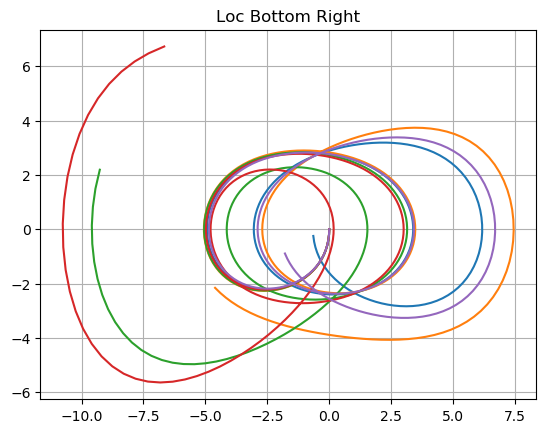

PyObject Text(0.5, 1, 'Loc Bottom Right')

In [61]:
initial_position[1]=0. #xz0[jj]
initial_momentum[1]=0. #pz1[jj]
initial_position[2]=Xraros[1]#Xz0[jj]
initial_momentum[2]=Praros[1]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(sol3[3,:],sol3[1,:])
initial_position[2]=Xraros[2]#Xz0[jj]
initial_momentum[2]=Praros[2]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(sol3[3,:],sol3[1,:])
initial_position[2]=Xraros[3]#Xz0[jj]
initial_momentum[2]=Praros[3]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(sol3[3,:],sol3[1,:])
initial_position[2]=Xraros[4]#Xz0[jj]
initial_momentum[2]=Praros[4]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(sol3[3,:],sol3[1,:])
initial_position[2]=Xraros[5]#Xz0[jj]
initial_momentum[2]=Praros[5]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(sol3[3,:],sol3[1,:])
PyPlot.grid(true)
title("Loc Bottom Right")

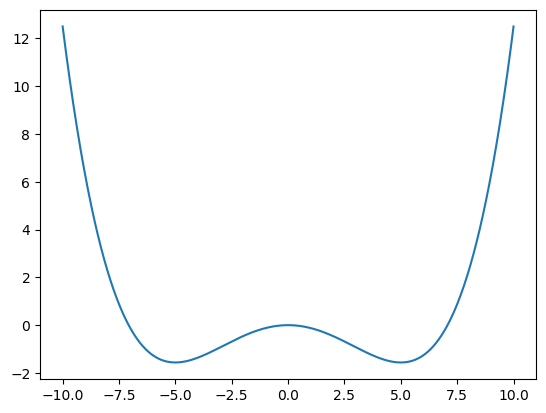

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x155f0bb10>

In [44]:
f(x)=-a*x*x*0.5+b*x*x*x*x*0.25
xarray=range(-10,stop=10,length=1000)
yarray=f.(xarray)
plot(xarray,yarray)

In [63]:
Hparticle(x,p)=p^2. /(2. ^m[1])-a*x*x*0.5+b*x*x*x*x*0.25
Hosci(x,p)=p^2. /(2. *m[2])+0.5*m[2]*w[2]*w[2]*x*x
Hinteract(x,X)=x*g[2]*X

Hinteract (generic function with 1 method)

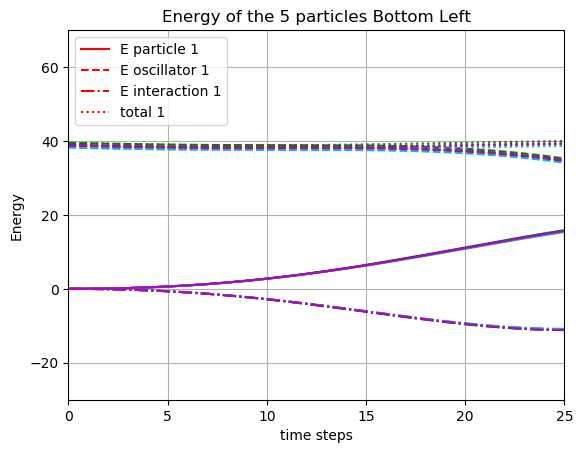

In [120]:
ppp=1
initial_position[1]=0. #xz0[jj]
initial_momentum[1]=0. #pz1[jj]
initial_position[2]=Xraros[1]#Xz0[jj]
initial_momentum[2]=Praros[1]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(Hparticle.(sol3[3,:],sol3[1,:]),label="E particle $ppp", color="r")
plot(Hosci.(sol3[4,:],sol3[2,:]),label="E oscillator $ppp",color="r","--")
plot(Hinteract.(sol3[3,:],sol3[4,:]),label="E interaction $ppp",color="r","-.")
plot(Hparticle.(sol3[3,:],sol3[1,:]).+Hosci.(sol3[4,:],sol3[2,:]).+Hinteract.(sol3[3,:],sol3[4,:]),label="total $ppp",color="r",":")

ppp+=1


initial_position[2]=Xraros[2]#Xz0[jj]
initial_momentum[2]=Praros[2]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(Hparticle.(sol3[3,:],sol3[1,:]),color="g")
plot(Hosci.(sol3[4,:],sol3[2,:]),color="g","--")
plot(Hinteract.(sol3[3,:],sol3[4,:]),color="g","-.")
plot(Hparticle.(sol3[3,:],sol3[1,:]).+Hosci.(sol3[4,:],sol3[2,:]).+Hinteract.(sol3[3,:],sol3[4,:]),color="g",":")


ppp+=1
initial_position[2]=Xraros[3]#Xz0[jj]
initial_momentum[2]=Praros[3]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
continua=plot(Hparticle.(sol3[3,:],sol3[1,:]),color="b")
plot(Hosci.(sol3[4,:],sol3[2,:]),color="b","--")
plot(Hinteract.(sol3[3,:],sol3[4,:]),color="b","-.")
plot(Hparticle.(sol3[3,:],sol3[1,:]).+Hosci.(sol3[4,:],sol3[2,:]).+Hinteract.(sol3[3,:],sol3[4,:]),color="b",":")


ppp+=1
initial_position[2]=Xraros[4]#Xz0[jj]
initial_momentum[2]=Praros[4]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(Hparticle.(sol3[3,:],sol3[1,:]),color="c")
plot(Hosci.(sol3[4,:],sol3[2,:]),color="c","--")
plot(Hinteract.(sol3[3,:],sol3[4,:]),color="c","-.")
plot(Hparticle.(sol3[3,:],sol3[1,:]).+Hosci.(sol3[4,:],sol3[2,:]).+Hinteract.(sol3[3,:],sol3[4,:]),color="c",":")


ppp+=1
initial_position[2]=Xraros[5]#Xz0[jj]
initial_momentum[2]=Praros[5]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(Hparticle.(sol3[3,:],sol3[1,:]),color="m")
plot(Hosci.(sol3[4,:],sol3[2,:]),color="m","--")
plot(Hinteract.(sol3[3,:],sol3[4,:]),color="m","-.")
plot(Hparticle.(sol3[3,:],sol3[1,:]).+Hosci.(sol3[4,:],sol3[2,:]).+Hinteract.(sol3[3,:],sol3[4,:]),color="m",":")


PyPlot.grid(true)
title("Energy of the 5 particles Bottom Left")
ylabel("Energy")
xlabel("time steps")
ylim([-30,70])
xlim([-0,25])
legend(loc="upper left")
savefig("short_parts5BL.png")


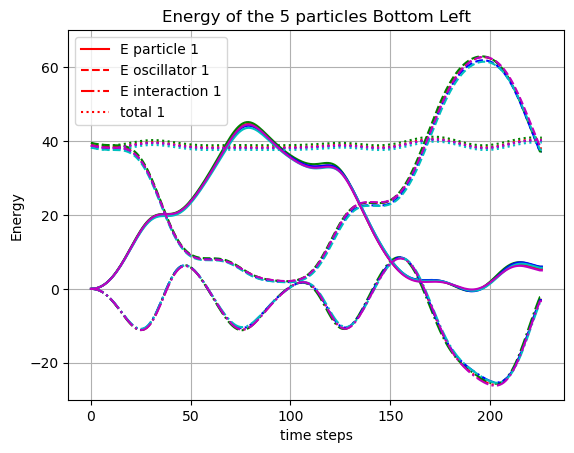

In [106]:
ppp=1
initial_position[1]=0. #xz0[jj]
initial_momentum[1]=0. #pz1[jj]
initial_position[2]=Xraros[1]#Xz0[jj]
initial_momentum[2]=Praros[1]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(Hparticle.(sol3[3,:],sol3[1,:]),label="E particle $ppp", color="r")
plot(Hosci.(sol3[4,:],sol3[2,:]),label="E oscillator $ppp",color="r","--")
plot(Hinteract.(sol3[3,:],sol3[4,:]),label="E interaction $ppp",color="r","-.")
plot(Hparticle.(sol3[3,:],sol3[1,:]).+Hosci.(sol3[4,:],sol3[2,:]).+Hinteract.(sol3[3,:],sol3[4,:]),label="total $ppp",color="r",":")

ppp+=1


initial_position[2]=Xraros[2]#Xz0[jj]
initial_momentum[2]=Praros[2]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(Hparticle.(sol3[3,:],sol3[1,:]),color="g")
plot(Hosci.(sol3[4,:],sol3[2,:]),color="g","--")
plot(Hinteract.(sol3[3,:],sol3[4,:]),color="g","-.")
plot(Hparticle.(sol3[3,:],sol3[1,:]).+Hosci.(sol3[4,:],sol3[2,:]).+Hinteract.(sol3[3,:],sol3[4,:]),color="g",":")


ppp+=1
initial_position[2]=Xraros[3]#Xz0[jj]
initial_momentum[2]=Praros[3]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
continua=plot(Hparticle.(sol3[3,:],sol3[1,:]),color="b")
plot(Hosci.(sol3[4,:],sol3[2,:]),color="b","--")
plot(Hinteract.(sol3[3,:],sol3[4,:]),color="b","-.")
plot(Hparticle.(sol3[3,:],sol3[1,:]).+Hosci.(sol3[4,:],sol3[2,:]).+Hinteract.(sol3[3,:],sol3[4,:]),color="b",":")


ppp+=1
initial_position[2]=Xraros[4]#Xz0[jj]
initial_momentum[2]=Praros[4]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(Hparticle.(sol3[3,:],sol3[1,:]),color="c")
plot(Hosci.(sol3[4,:],sol3[2,:]),color="c","--")
plot(Hinteract.(sol3[3,:],sol3[4,:]),color="c","-.")
plot(Hparticle.(sol3[3,:],sol3[1,:]).+Hosci.(sol3[4,:],sol3[2,:]).+Hinteract.(sol3[3,:],sol3[4,:]),color="c",":")


ppp+=1
initial_position[2]=Xraros[5]#Xz0[jj]
initial_momentum[2]=Praros[5]#Pz1[jj]
    
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol3 = solve(prob, CalvoSanz4(), dt=dts);
plot(Hparticle.(sol3[3,:],sol3[1,:]),color="m")
plot(Hosci.(sol3[4,:],sol3[2,:]),color="m","--")
plot(Hinteract.(sol3[3,:],sol3[4,:]),color="m","-.")
plot(Hparticle.(sol3[3,:],sol3[1,:]).+Hosci.(sol3[4,:],sol3[2,:]).+Hinteract.(sol3[3,:],sol3[4,:]),color="m",":")

ylim([-30,70])
PyPlot.grid(true)
title("Energy of the 5 particles Bottom Left")
ylabel("Energy")
xlabel("time steps")
legend(loc="upper left")
savefig("parts5BL.png")



In [70]:
ggg=[1,2,3,4]
ggg2=[2,3,4,5]
ggg.+ggg2

4-element Array{Int64,1}:
 3
 5
 7
 9